# Final Project: Identifying Areas of Concern for Heat-Related Illness in the United States

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
from IPython import display
%config InlineBackend.figure_format = 'retina'
import xarray as xr
import numpy as np

In [4]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

### Figures 1 & 2: Visualizing Relative Humidity and Surface Air Temperature (1981-2010)

The first phase of this project involved identifying current areas of concern for heat-related illness based on heat-index and wet-bulb temperature. To identify these areas, specific humidity and surface air temperature data files were obtained from NOAA NCEP-NCAR CDAS-1 1981-2010 Climatology [P=1000mb, M=August] from the IRI database.

In [39]:
noaa_sh = xr.open_dataset('noaa_sh.nc', decode_times=False)
noaa_temp = xr.open_dataset('noaa_temp.nc', decode_times=False)

These data files were merged into a single dataset. Specific humidity values (qa) were used to calculate relative humidity using the Clausius-Clapeyron equation, which were converted to degrees Celsius.

In [40]:
hi = xr.merge([noaa_sh, noaa_temp])

In [41]:
hi = hi.assign(humidity = lambda hi: 0.263 * 100000 * hi.qa / ( np.exp(17.67 * (hi.temp-273.15) / (hi.temp-29.65)) ))
hi['temp'] = hi.temp - 273.15

In [42]:
humidity = hi.humidity.sel(T=7.5, P=1000, method='nearest')
temp = hi.temp.sel(T=7.5, P=1000, method='nearest')
lon = hi.X
lat = hi.Y

Figures 1 and 2 (below) visualize average surface air temperature and relative humidity during August (averaged over 1981-2010), which will be used to calculate heat-index and wet-bulb temperature.

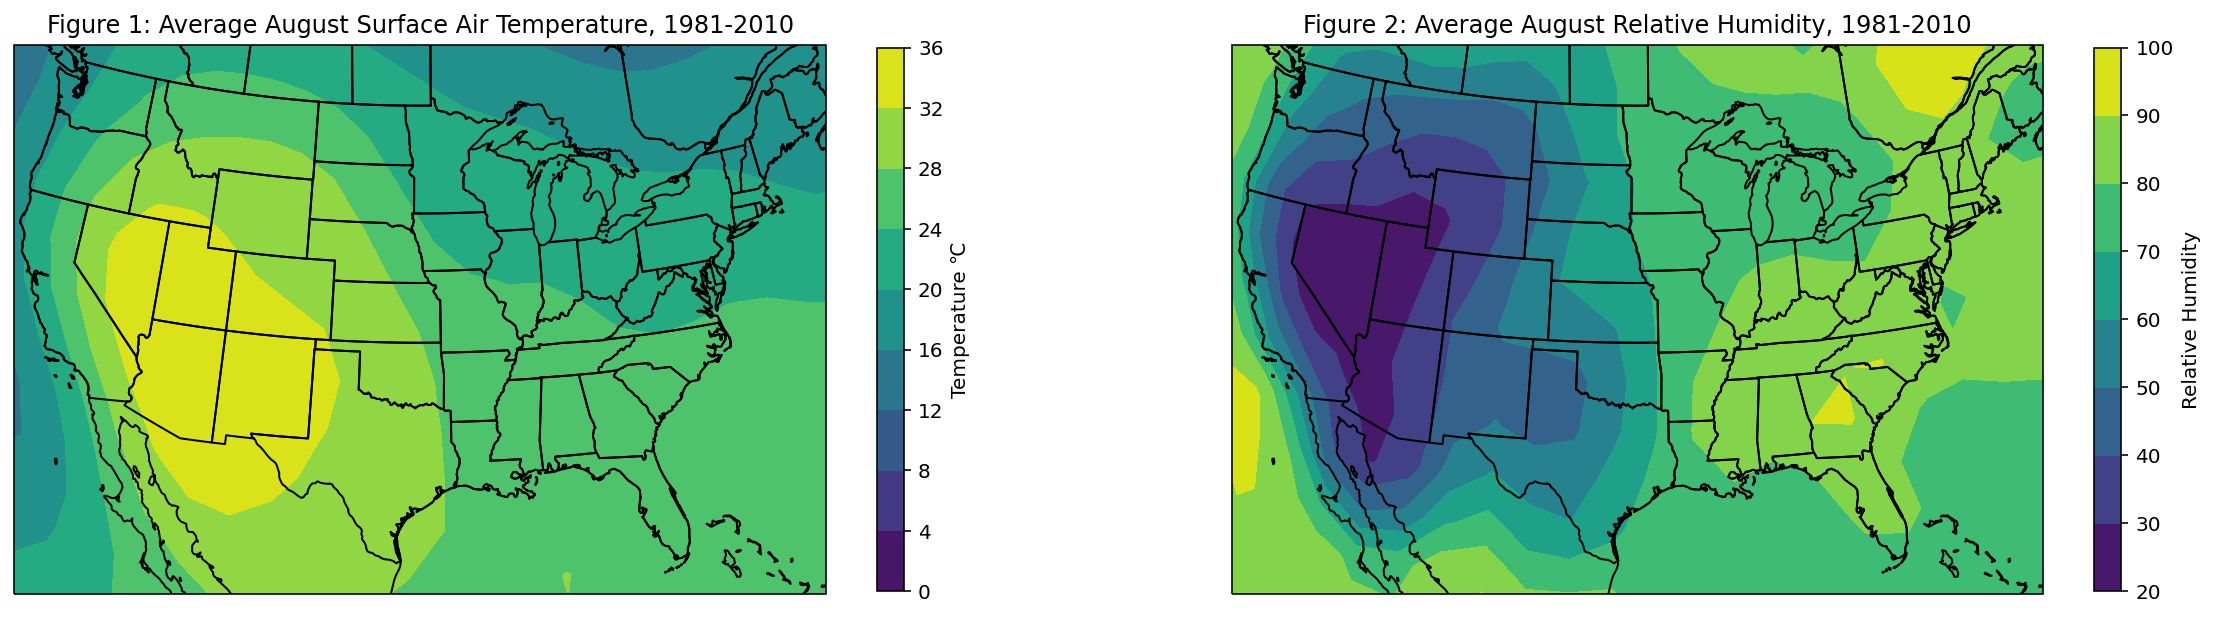

In [9]:
extent = [-119, -73, 22, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax1.set_extent(extent)
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
cf0 = ax1.contourf(lon, lat, temp, transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(cf0, ax=ax1, shrink=0.5)
cbar1.ax.set_ylabel("Temperature " + u"\u2103")
ax1.set_title('Figure 1: Average August Surface Air Temperature, 1981-2010')

ax2 = plt.subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax2.set_extent(extent)
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
cf1 = ax2.contourf(lon, lat, humidity, transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(cf1, ax=ax2, shrink=0.5)
cbar2.ax.set_ylabel("Relative Humidity")
ax2.set_title('Figure 2: Average August Relative Humidity, 1981-2010');

### Figures 3 & 4: Calculating and Visualizing Heat Index and Wet-Bulb Temperature (1981-2010)

Using the surface air tempreature and relative humidity mapped above, the heat-index and wet-bulb can be calculated for the United States. Heat-index is calculated using the Rothfusz regression equation (1990), and wet-bulb temperature is calculated using an empirical expression from Stull (2011).

In [43]:
temp_F = hi.temp * (9/5) + 32

In [44]:
hi = hi.assign(heat_index = lambda hi: -42.379 + 2.04901523*temp_F + 10.14333127*hi.humidity - .22475541*temp_F*hi.humidity - .00683783*temp_F**2 - .05481717*hi.humidity**2 + .00122874*(temp_F**2)*hi.humidity + .00085282*temp_F*(hi.humidity**2) - .00000199*(temp_F**2)*(hi.humidity**2))
hi = hi.assign(temp_wb = lambda hi:  hi.temp*np.arctan(0.151977*np.sqrt(hi.humidity+8.313659)) + np.arctan(hi.temp+hi.humidity) - np.arctan(hi.humidity-1.676331) + (0.00391838*(hi.humidity)**(3/2))*np.arctan(0.023101*hi.humidity) - 4.686035 )

In [45]:
heat_index = hi.heat_index.sel(T=7.5, P=1000, method='nearest')
temp_wb = hi.temp_wb.sel(T=7.5, P=1000, method='nearest')

Figures 3 and 4 (below) visualize average heat-index and wet-bulb temperature during August (averaged over 1981-2010). Heat-index values have been labelled with NWS Heat Index categories. Wet-bulb temperatures above 26 degrees Celcius are considered extreme heat events (Sherwood and Huber 2010).

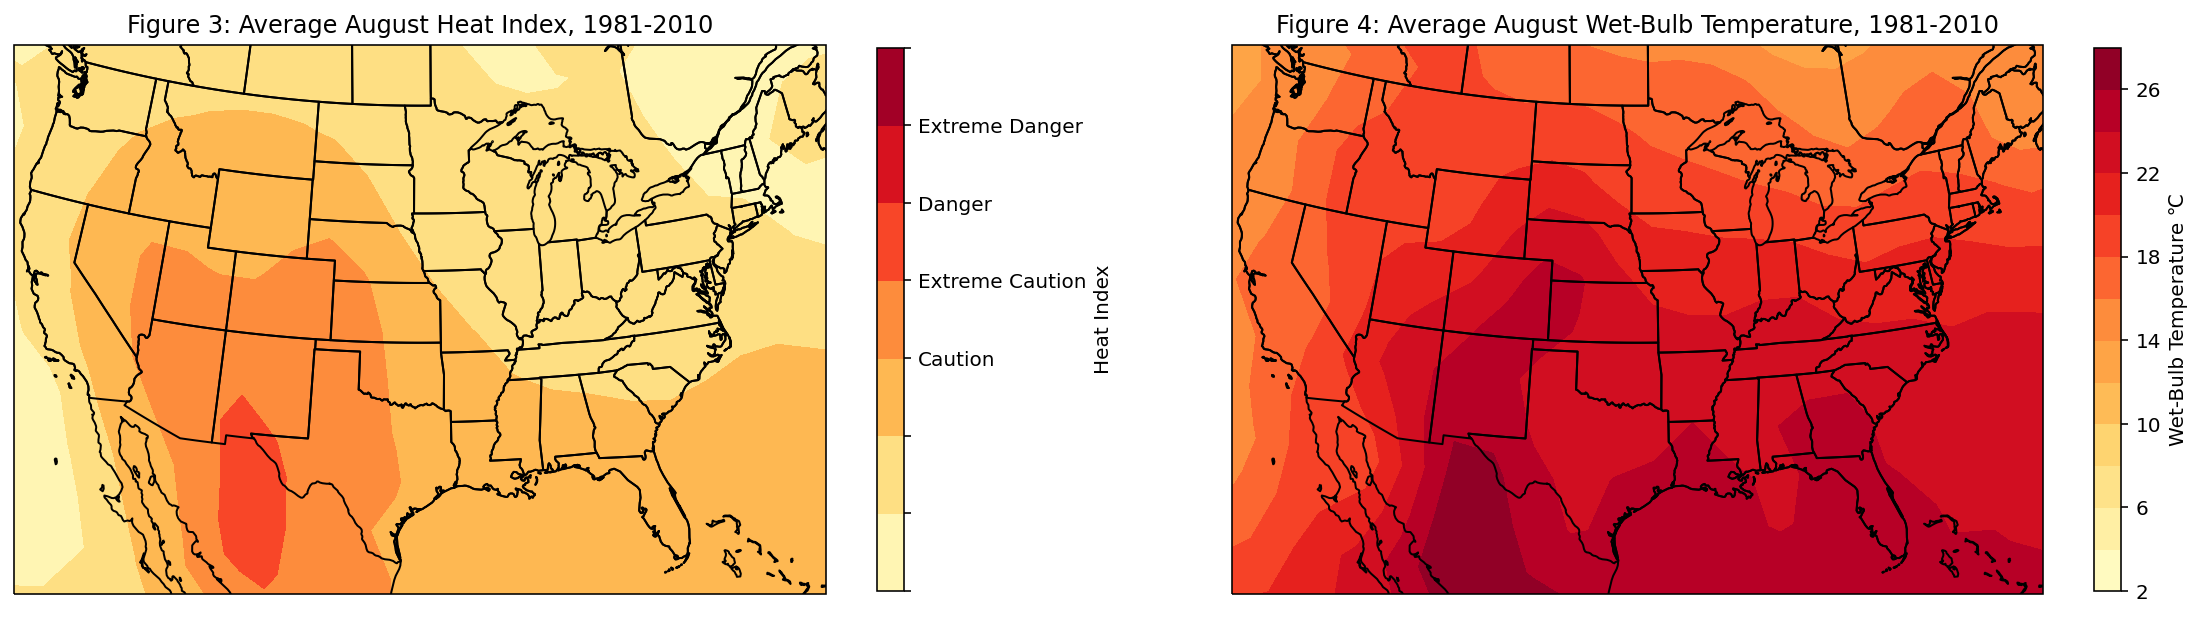

In [47]:
extent = [-119, -73, 22, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax1.set_extent(extent)
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
cf0 = ax1.contourf(lon, lat, heat_index, cmap='YlOrRd', transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(cf0, ax=ax1, shrink=0.5)
cbar1.ax.set_ylabel("Heat Index")
cbar1.ax.set_yticklabels(['','','','Caution','Extreme Caution','Danger','Extreme Danger',' '])
ax1.set_title('Figure 3: Average August Heat Index, 1981-2010')

ax2 = plt.subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax2.set_extent(extent)
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
cf1 = ax2.contourf(lon, lat, temp_wb, cmap='YlOrRd', levels=16, transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(cf1, ax=ax2, shrink=0.5)
cbar2.ax.set_ylabel("Wet-Bulb Temperature " + u"\u2103")
ax2.set_title('Figure 4: Average August Wet-Bulb Temperature, 1981-2010');

### Figures 5 & 6: Visualizing Projected Relative Humidity and Surface Air Temperature (2090-2099)

The second phase of this project involved identifying potential areas of concern for heat-related illness by the end of the century based on heat-index and wet-bulb temperature. Similar to phase one, specific humidity and surface air temperature data files were obtained from the CMIP5 GFDL CM3 model during August 2090-2099 under the RCP-85 scenario [P=1000mb].

In [30]:
noaa_sh_proj = xr.open_dataset('noaa_sh_proj.cdf', decode_times=False)
noaa_temp_proj = xr.open_dataset('noaa_temp_proj.cdf', decode_times=False)

These data files were merged into a single dataset. Specific humidity values (huss) were used to calculate relative humidity using the Clausius-Clapeyron equation, which were converted to degrees Celsius.

In [31]:
hi_proj = xr.merge([noaa_sh_proj, noaa_temp_proj])

In [32]:
sh = noaa_sh_proj.huss
temp = noaa_temp_proj.tas
hi_proj = hi_proj.assign(humidity = lambda hi_proj: 0.263 * 100000 * sh / ( np.exp(17.67 * (temp-273.15) / (temp-29.65)) ))
hi_proj['temp'] = hi_proj.tas - 273.15

In [33]:
humidity = hi_proj.humidity
temp = hi_proj.temp
lon = hi_proj.lon
lat = hi_proj.lat

Figures 5 and 6 (below) visualize average surface air temperature and relative humidity during August (averaged over 2090-2099), which will be used to calculate heat-index and wet-bulb temperature.

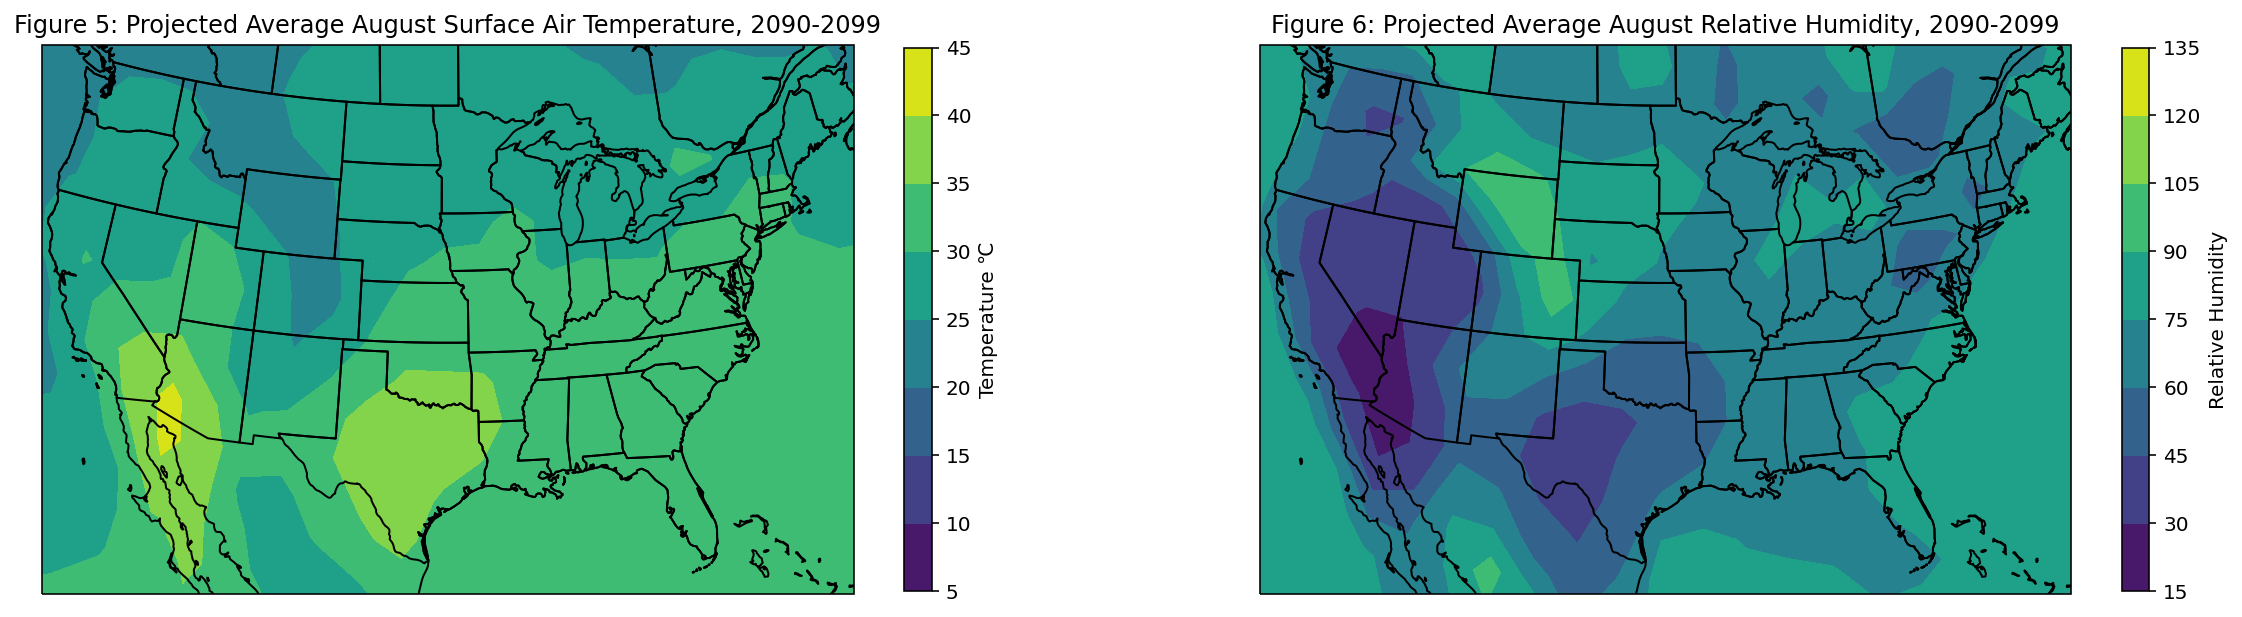

In [34]:
extent = [-119, -73, 22, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax1.set_extent(extent)
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
cf0 = ax1.contourf(lon, lat, temp, transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(cf0, ax=ax1, shrink=0.5)
cbar1.ax.set_ylabel("Temperature " + u"\u2103")
ax1.set_title('Figure 5: Projected Average August Surface Air Temperature, 2090-2099')

ax2 = plt.subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax2.set_extent(extent)
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
cf1 = ax2.contourf(lon, lat, humidity, transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(cf1, ax=ax2, shrink=0.5)
cbar2.ax.set_ylabel("Relative Humidity")
ax2.set_title('Figure 6: Projected Average August Relative Humidity, 2090-2099');

### Figures 7 & 8: Calculating and Visualizing Projected Heat Index and Wet-Bulb Temperature (2090-2099)

Using the surface air tempreature and relative humidity mapped above, the heat-index and wet-bulb can be calculated for the United States. Heat-index is calculated using the Rothfusz regression equation (1990), and wet-bulb temperature is calculated using an empirical expression from Stull (2011).

In [35]:
temp_F = hi_proj.temp * (9/5) + 32

In [36]:
hi_proj = hi_proj.assign(heat_index = lambda hi_proj: -42.379 + 2.04901523*temp_F + 10.14333127*humidity - .22475541*temp_F*humidity - .00683783*temp_F**2 - .05481717*humidity**2 + .00122874*(temp_F**2)*humidity + .00085282*temp_F*(humidity**2) - .00000199*(temp_F**2)*(humidity**2))
hi_proj = hi_proj.assign(temp_wb = lambda hi_proj:  temp*np.arctan(0.151977*np.sqrt(humidity+8.313659)) + np.arctan(temp+humidity) - np.arctan(humidity-1.676331) + (0.00391838*(humidity)**(3/2))*np.arctan(0.023101*humidity) - 4.686035 )

In [37]:
heat_index = hi_proj.heat_index
temp_wb = hi_proj.temp_wb

Figures 7 and 8 (below) visualize average heat-index and wet-bulb temperature during August (averaged over 2090-2099). Heat-index values have been labelled with NWS Heat Index categories. Wet-bulb temperatures above 26 degrees Celcius are considered extreme heat events (Sherwood and Huber 2010).

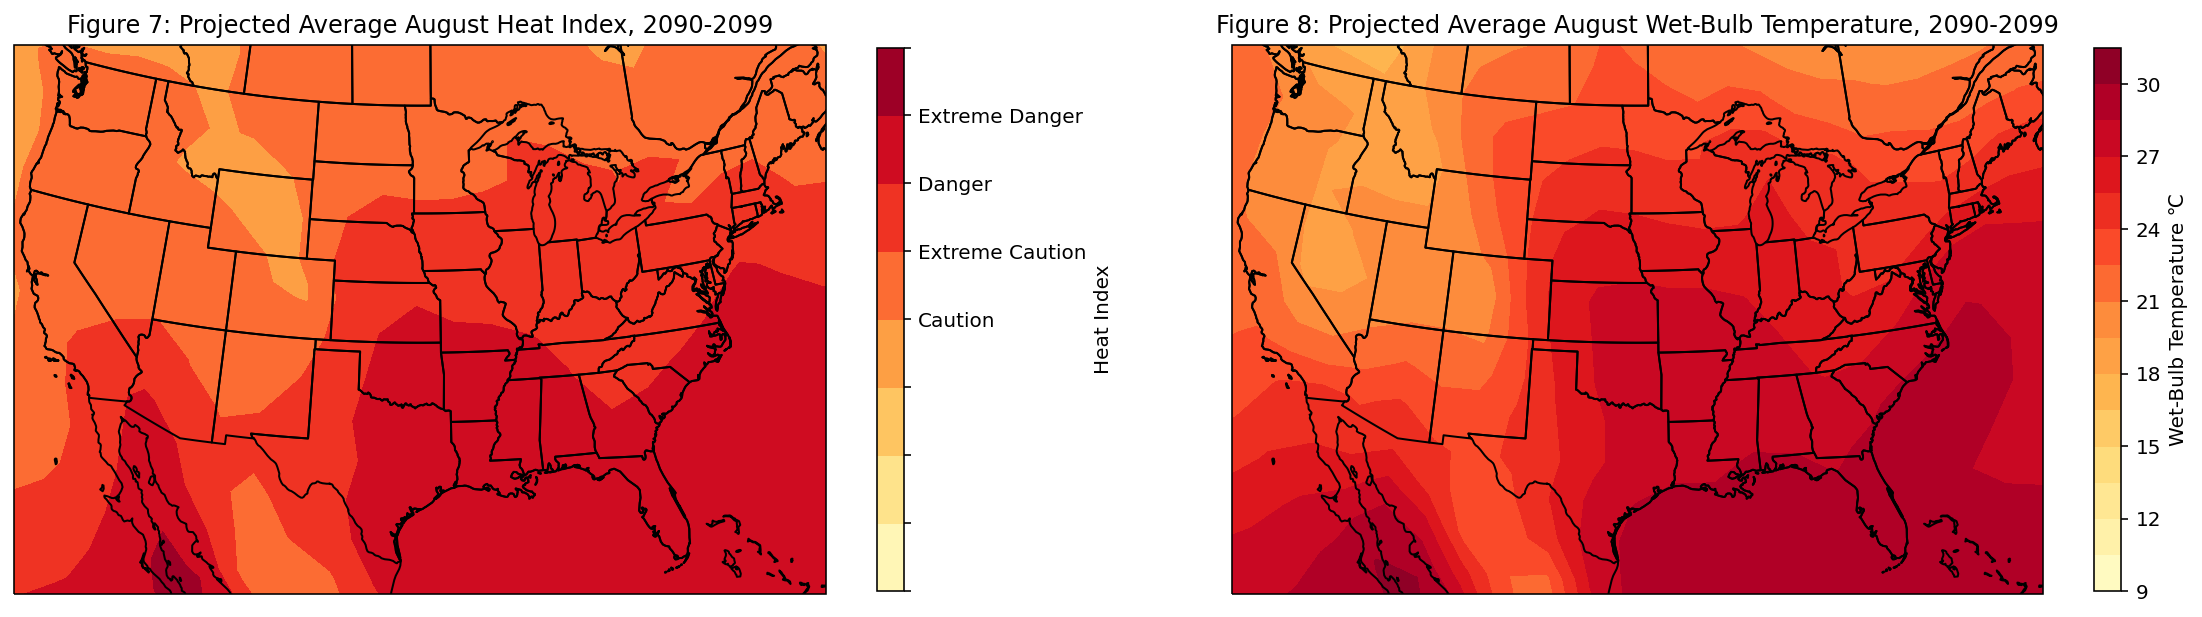

In [38]:
extent = [-119, -73, 22, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax1.set_extent(extent)
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
cf0 = ax1.contourf(lon, lat, heat_index, cmap='YlOrRd', transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(cf0, ax=ax1, shrink=0.5)
cbar1.ax.set_ylabel("Heat Index")
cbar1.ax.set_yticklabels(['','','','','Caution','Extreme Caution','Danger','Extreme Danger',' '])
ax1.set_title('Figure 7: Projected Average August Heat Index, 2090-2099')

ax2 = plt.subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax2.set_extent(extent)
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
cf1 = ax2.contourf(lon, lat, temp_wb, cmap='YlOrRd', levels=16, transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(cf1, ax=ax2, shrink=0.5)
cbar2.ax.set_ylabel("Wet-Bulb Temperature " + u"\u2103")
ax2.set_title('Figure 8: Projected Average August Wet-Bulb Temperature, 2090-2099');

### Conclusions:

While Figures 3 and 4 indicate that the southwestern United States is currently at the greatest risk of heat-related illness, the projected heat-index and wet-bulb temperatures (Figures 7 and 8) suggest the southeastern United States will experience the greatest increase in risk of heat-related illness by the end of the century. As a follow-up to this analysis, I plan to investigate current and projected concentrations of air pollution in the United States to identify how areas of poor air quality overlap with areas at risk of extreme heat events. This is of particular interest given the growing evidence of effect modification from air pollution exposure on heat-related mortality.